# 日本ガイシ 日足

In [1]:
import sys
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '5333.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='3mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-12-05 00:00:00+09:00,1983.5,1994.5,1975.0,1982.5,527200,0.0,0.0
2024-12-06 00:00:00+09:00,1978.0,1984.0,1945.5,1960.0,515800,0.0,0.0
2024-12-09 00:00:00+09:00,1978.5,2009.5,1976.0,1979.0,845800,0.0,0.0
2024-12-10 00:00:00+09:00,2000.0,2003.5,1980.5,1988.0,447800,0.0,0.0
2024-12-11 00:00:00+09:00,1990.0,1998.0,1972.5,1989.0,744100,0.0,0.0
2024-12-12 00:00:00+09:00,2005.0,2012.5,1996.5,2001.5,743800,0.0,0.0
2024-12-13 00:00:00+09:00,1996.0,2009.0,1973.0,1984.5,929200,0.0,0.0
2024-12-16 00:00:00+09:00,1980.0,1985.0,1956.0,1961.5,696200,0.0,0.0
2024-12-17 00:00:00+09:00,1965.0,1971.0,1942.0,1943.5,511000,0.0,0.0


## 日足チャートとパラボリック SAR

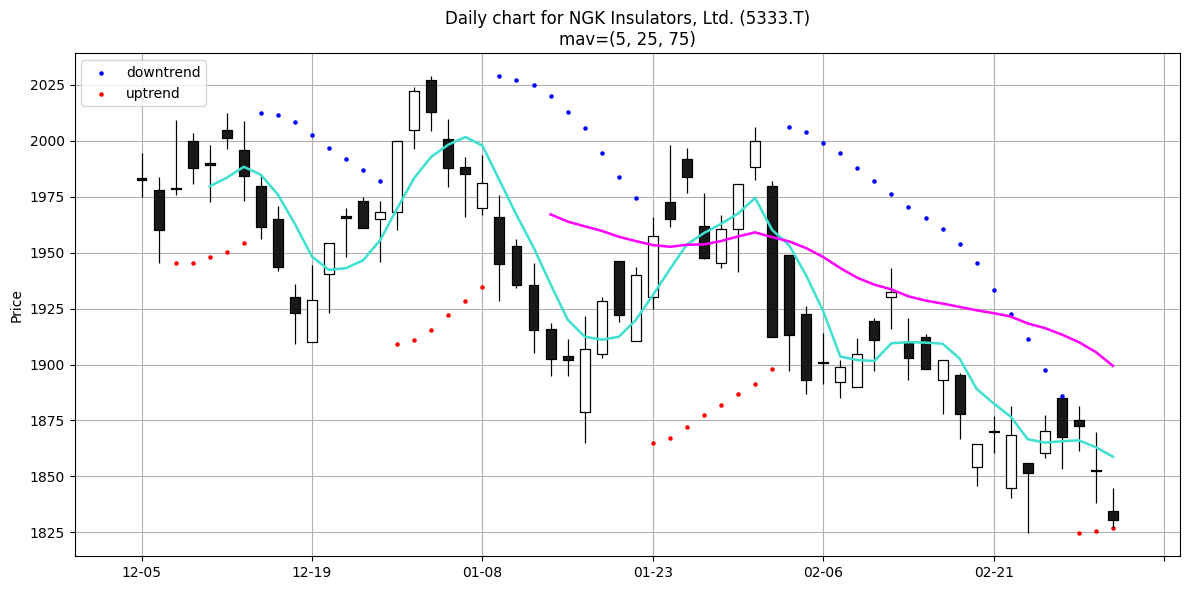

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-01-20 00:00:00+09:00    1928.5
2025-01-21 00:00:00+09:00    1922.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-01-20 00:00:00+09:00    NaN
2025-01-21 00:00:00+09:00   -6.5
Name: Close, dtype: float64